In [1]:
#!pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 KB 2.0 MB/s eta 0:00:0000:0100:01


In [100]:
import praw
import pandas as pd
 
reddit_read_only = praw.Reddit(client_id="-FkFx07VGHhRLGZW9CNuRw",         # your client id
                               client_secret="LP6ZvPq-t4OmaNm8xtIjkxHLRC7N0A",      # your client secret
                               user_agent="MK scraper")        # your user agent
 
 
subrdit = reddit_read_only.subreddit("AmITheAsshole")
 
# Display the name of the Subreddit
#print("Display Name:", subrdit.display_name)
 
# Display the description of the Subreddit
#print("Description:", subrdit.description)

In [101]:
subreddit = reddit_read_only.subreddit("AmITheAsshole")
 
for post in subreddit.top(limit=5):
    print(post.title)
    print()

AITA for telling my wife the lock on my daughter's door does not get removed til my brother inlaw and his daughters are out of our house?

META: This sub is moving towards a value system that frequently doesn't align with the rest of the world

UPDATE, AITA for despising my mentally handicap sister?

AITA For suing my girlfriend after she had my 1967 impala project taken to the scrapyard?

AITA for bringing my SIL’s wallet to the restaurant when she conveniently always forgets it?



In [ ]:
posts = subreddit.top("year", limit = 800)

posts_dict = {'title' : [], 'body': [], 'score': [], 'id': [], 'top_comment_body' : [], 'top_comment_score': [], 'url': []}

i=0
for post in posts:
    # Title of each post
    posts_dict["title"].append(post.title)
     
    # Text inside a post
    posts_dict["body"].append(post.selftext)
     
    # Unique ID of each post
    posts_dict["id"].append(post.id)
     
    # The score of a post
    posts_dict["score"].append(post.score)
    
    # Text inside the top comment of the post
    posts_dict["top_comment_body"].append(post.comments[1].body)
    
    # Score of the top comment of the post
    posts_dict["top_comment_score"].append(post.comments[1].score)
     
    # URL of each post
    posts_dict["url"].append(post.url)
    
    if i%10 == 0:
        print("Done with post number ", i)
    i += 1
    
# Saving the data in a pandas dataframe
top_posts = pd.DataFrame(posts_dict)
top_posts


Done with post number  0
Done with post number  10
Done with post number  20
Done with post number  30


In [103]:
top_posts.to_csv('TM_project/reddit_posts.csv', index=False)

In [104]:
import pickle # for loading (and saving) the previously web scraped data

import pandas as pd # for processing data in dataframes
import matplotlib.pyplot as plt # for plotting

import re # for cleaning textual data (uses regular expressions ouch!)
from collections import Counter # for counting tokens occurences
import math # for calculations

import nltk
from nltk.tokenize import word_tokenize # for tokenization
from nltk.stem import PorterStemmer # for stemming
from nltk.corpus import stopwords

# import stop_words # source: https://pypi.org/project/stop-words/#installation
# from stop_words import get_stop_words # alternative stopwords list

import gensim
from gensim import corpora # for: Dictionary(), word2bow()
from gensim import models # for: TfidfModel()

import statistics # for: quantiles()

import numpy as np # for some maths

import time # for measuring time of computation

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [105]:
#removing \n
post_texts = top_posts["body"].map(lambda x: re.sub('\n', ' ', x))

#removing all numbers
post_texts = post_texts.map(lambda x: re.sub(r'[0-9]+', '', x))

#removing ,\!?/:;''()``’“-”—#
post_texts = post_texts.map(lambda x: re.sub("[,\!?/:;''()``’“-”—#]", '', x))

#removing .
post_texts = post_texts.map(lambda x: re.sub(r"([.]+)", '', x))

#all letters to lover case
post_texts = post_texts.map(lambda x: x.lower())

#removing one-letter words
post_texts = post_texts.map(lambda x: re.sub(r'\b\w\b', '', x))

post_texts

0      edit update on profile  my  sil amy  always co...
1       am  nurse practitioner and  am the primary ca...
2       have  sister thats  years older than me   my ...
3      hello    dont know where to beginits been an a...
4          dont have the best relationship with my hu...
                             ...                        
295    for the past few months   havent had  good rel...
296    for over  decade myself and my four best frien...
297    on mobile and ive never posted here before so ...
298    the title sounds bad but hear me out    had  w...
299    about  weeks ago my wife- went into premature ...
Name: body, Length: 300, dtype: object

In [106]:
#word_tokenize() applied to every single text
for i in range(0,len(post_texts)):
    post_texts[i] = word_tokenize(post_texts[i])
    
post_texts

0      [edit, update, on, profile, my, sil, amy, alwa...
1      [am, nurse, practitioner, and, am, the, primar...
2      [have, sister, thats, years, older, than, me, ...
3      [hello, dont, know, where, to, beginits, been,...
4      [dont, have, the, best, relationship, with, my...
                             ...                        
295    [for, the, past, few, months, havent, had, goo...
296    [for, over, decade, myself, and, my, four, bes...
297    [on, mobile, and, ive, never, posted, here, be...
298    [the, title, sounds, bad, but, hear, me, out, ...
299    [about, weeks, ago, my, wife-, went, into, pre...
Name: body, Length: 300, dtype: object

In [107]:
ps = PorterStemmer()

for i in range(0,len(post_texts)):
    
    words = []
    for word in post_texts[i]:
        words.append(ps.stem(word)) #stems every token in document and append it to a list
                                    #it takes few minutes

post_texts

0      [edit, update, on, profile, my, sil, amy, alwa...
1      [am, nurse, practitioner, and, am, the, primar...
2      [have, sister, thats, years, older, than, me, ...
3      [hello, dont, know, where, to, beginits, been,...
4      [dont, have, the, best, relationship, with, my...
                             ...                        
295    [for, the, past, few, months, havent, had, goo...
296    [for, over, decade, myself, and, my, four, bes...
297    [on, mobile, and, ive, never, posted, here, be...
298    [the, title, sounds, bad, but, hear, me, out, ...
299    [about, weeks, ago, my, wife-, went, into, pre...
Name: body, Length: 300, dtype: object

In [108]:
stop_words = nltk.corpus.stopwords.words('english') #one of stopwords dictionaries available in Python

# cleaning stopwords
stop_words = pd.Series(stop_words).map(lambda x: re.sub('\n', '', x))
stop_words = stop_words.map(lambda x: re.sub("[,\!?/:;''()``]", '', x))
stop_words = stop_words.map(lambda x: re.sub(r"([.]+)", '', x))

# stemming stopwords
ps = PorterStemmer()
for i in range(0,len(stop_words)):
    stop_words[i] = ps.stem(stop_words[i])

In [109]:
#making stopwords back a list
stop_words = list(stop_words)

#adding some specific stopwords
stop_words.append('``')
stop_words.append("\'\'")

In [110]:
# removing stopwords from post texts
for i in range(0,len(post_texts)):
    post_texts[i] = [word for word in post_texts[i] if not word in list(stop_words)]
post_texts

0      [edit, update, profile, sil, amy, always, come...
1      [nurse, practitioner, primary, care, provider,...
2      [sister, thats, years, older, parents, years, ...
3      [hello, know, beginits, absolute, nightmare, r...
4      [best, relationship, husbands, mom, since, day...
                             ...                        
295    [past, months, good, relationship, mom, stepda...
296    [decade, four, best, friends, annual, fishing,...
297    [mobile, ive, never, posted, before, sorry, ad...
298    [title, sounds, bad, hear, work, colleagues, m...
299    [weeks, ago, wife-, went, premature, labor, da...
Name: body, Length: 300, dtype: object

In [111]:
top_posts["body_clean"] = post_texts
top_posts.head()

title  \
0  AITA for bringing my SIL’s wallet to the resta...   
1  AITA for bringing up my brother's "premature" ...   
2  AITA for not taking down my video that was a g...   
3  UPDATE AITA for walking out of the Airport whe...   
4  AITA for walking out of the Airport when I saw...   

                                                body  score      id  \
0  Edit: update on profile\n\nMy (f28) SIL “Amy” ...  68476  x2k5kv   
1  I am a nurse practitioner and I am the primary...  56113  zvmflw   
2  I have a sister that’s 6 years older than me. ...  54700  wyjbjs   
3  Hello!.\n\n\nI don't know where to begin...it'...  51466  ur2l3s   
4  \n\nI F30 don't have the best relationship wit...  50032  unhse2   

                                    top_comment_body  top_comment_score  \
0  NTA. Stone cold busted. Next time she books an...               1443   
1  You can tell the family about the time you wer...                673   
2  NTA\n\nMy parents missed my wedding too all be...               1563   
3  I'm sorry you are going through this, but I'm ...              18673   
4  Definitely NTA. You know that if you had sucke...               9414   

                                                 url  \
0  https://www.reddit.com/r/AmItheAsshole/comment...   
1  https://www.reddit.com/r/AmItheAsshole/comment...   
2  https://www.reddit.com/r/AmItheAsshole/comment...   
3  https://www.reddit.com/r/AmItheAsshole/comment...   
4  https://www.reddit.com/r/AmItheAsshole/comment...   

                                          body_clean  \
0  [edit, update, profile, sil, amy, always, come...   
1  [nurse, practitioner, primary, care, provider,...   
2  [sister, thats, years, older, parents, years, ...   
3  [hello, know, beginits, absolute, nightmare, r...   
4  [best, relationship, husbands, mom, since, day...   

                                      body_clean_str  
0  edit update profile sil amy always comes visit...  
1  nurse practitioner primary care provider lot l...  
2  sister thats years older parents years cancel ...  
3  hello know beginits absolute nightmare recentl...  
4  best relationship husbands mom since day one t...

In [112]:
def generate_ngrams(text, ngram = 1):
    temp = zip(*[text[i:] for i in range(0,ngram)]) # set with pairs, three, ..., ns of tokens
    ans = [' '.join(ngram) for ngram in temp] # joins the elements in strings
    ans = pd.Series(ans).map(lambda x: re.sub(" ", '_', x)) # replaces spaces with '_'
    return list(ans)

In [113]:
for i in range(0,len(post_texts)):
    unigrams = post_texts[i]
    bigrams = generate_ngrams(post_texts[i], ngram = 2)
    trigrams = generate_ngrams(post_texts[i], ngram = 3)
    
    text = []
    text.append(unigrams)
    text.append(bigrams)
    text.append(trigrams)
    
    post_texts[i] = [item for sublist in text for item in sublist] 

post_texts

0      [edit, update, profile, sil, amy, always, come...
1      [nurse, practitioner, primary, care, provider,...
2      [sister, thats, years, older, parents, years, ...
3      [hello, know, beginits, absolute, nightmare, r...
4      [best, relationship, husbands, mom, since, day...
                             ...                        
295    [past, months, good, relationship, mom, stepda...
296    [decade, four, best, friends, annual, fishing,...
297    [mobile, ive, never, posted, before, sorry, ad...
298    [title, sounds, bad, hear, work, colleagues, m...
299    [weeks, ago, wife-, went, premature, labor, da...
Name: body, Length: 300, dtype: object

In [114]:
#dictionary from gensim library = keys are: 1, 2, 3, ..., number of tokens; values are tokens' names
dictionary = corpora.Dictionary(post_texts) 

#corpus from gensim library consists of so called bows
#every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
corpus = [dictionary.doc2bow(text) for text in post_texts]

In [115]:
tfidf_model = models.TfidfModel(corpus, id2word = dictionary)

In [116]:
def TFIDF(dictionary, corpus, which_text, tfidf_model):
    bow = corpus[which_text]
    tfidfdictionary = dict(tfidf_model[bow]) #TFIDF for tokens in a chosen text
    
    #below: keys are tokens' names; values are numbers of tokens' occurences in text
    TFIDFdictionary = dict((dictionary[key], value) for (key, value) in tfidfdictionary.items())
    
    return(TFIDFdictionary)

In [117]:
TFIDF(dictionary, corpus, 0, tfidf_model)

{'*': 0.031102863677097987,
 '*_make': 0.05061342242450338,
 '*_make_fair': 0.05061342242450338,
 '*_specifically': 0.05061342242450338,
 '*_specifically_*': 0.05061342242450338,
 'admit': 0.024965248182888245,
 'admit_got': 0.05061342242450338,
 'admit_got_this': 0.05061342242450338,
 'aita': 0.005633693489139858,
 'aita_taking': 0.04446267049665244,
 'aita_taking_wallet': 0.05061342242450338,
 'always': 0.033572546303112225,
 'always_comes': 0.05061342242450338,
 'always_comes_visit': 0.05061342242450338,
 'always_conveniently': 0.05061342242450338,
 'always_conveniently_forgets': 0.05061342242450338,
 'always_wants': 0.05061342242450338,
 'always_wants_go': 0.05061342242450338,
 'amount': 0.026010414713099627,
 'amount_money': 0.04446267049665244,
 'amount_money_much': 0.05061342242450338,
 'amy': 0.11493575570640449,
 'amy_always': 0.05061342242450338,
 'amy_always_comes': 0.05061342242450338,
 'amy_called': 0.05061342242450338,
 'amy_called_saw': 0.05061342242450338,
 'amy_hopeful

In [118]:
d_tfidf = {}

for i in range(0,len(corpus)): # for each text
    data = TFIDF(dictionary, corpus, i, tfidf_model) # calculate TFIDF values for text's tokens

    for token, value in data.items(): # next, for each token and its TFIDF value in text, prepare a dictionary
                                      # with tokens' names as keys and list of TF-IDFs as values
        d_tfidf.setdefault(token, []).append(value)

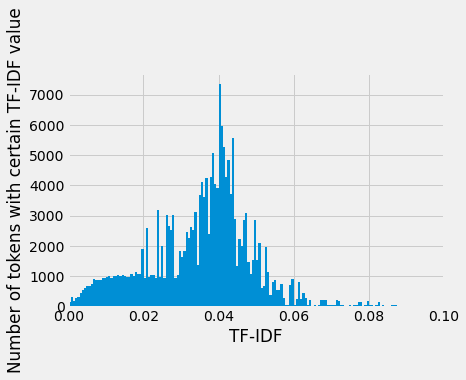

In [119]:
tfidf_values = [item for sublist in list(d_tfidf.values()) for item in sublist]

plt.hist(tfidf_values, bins=1000)
plt.xlabel('TF-IDF')
plt.ylabel('Number of tokens with certain TF-IDF value')
plt.xlim([0, 0.1])
plt.show()

In [120]:
for i in [0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5]:
    print('Quantile ',i*100,'%: ',np.quantile(tfidf_values,i),sep='')

Quantile 1.0%: 0.003853447973818966
Quantile 2.0%: 0.005620118285709149
Quantile 3.0%: 0.007058768639151794
Quantile 4.0%: 0.00832010279388287
Quantile 5.0%: 0.009537832916006732
Quantile 10.0%: 0.015092185936049572
Quantile 20.0%: 0.02401563201879645
Quantile 30.0%: 0.02975679129054517
Quantile 40.0%: 0.03465263755855396
Quantile 50.0%: 0.0378660894356494


In [121]:
import pickle # for saving objects

import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px # for nice plotting

import warnings

import math

from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer

from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM

from sklearn.decomposition import LatentDirichletAllocation # LDA implementation

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [122]:
# as our preprocessed data is already tokenized
# therefore, we need to make them strings again...

def listToString(s):  
    str1 = ""   
    for ele in s:  
        str1 += ele+" "    
    return str1  

top_posts["body_clean_str"] = top_posts["body_clean"] # new column, for now a copy of tokenized and preprocessed texts
for i in range(0,len(top_posts)):
    top_posts["body_clean_str"][i] = listToString(top_posts["body_clean_str"][i])
    
top_posts.head()

title  \
0  AITA for bringing my SIL’s wallet to the resta...   
1  AITA for bringing up my brother's "premature" ...   
2  AITA for not taking down my video that was a g...   
3  UPDATE AITA for walking out of the Airport whe...   
4  AITA for walking out of the Airport when I saw...   

                                                body  score      id  \
0  Edit: update on profile\n\nMy (f28) SIL “Amy” ...  68476  x2k5kv   
1  I am a nurse practitioner and I am the primary...  56113  zvmflw   
2  I have a sister that’s 6 years older than me. ...  54700  wyjbjs   
3  Hello!.\n\n\nI don't know where to begin...it'...  51466  ur2l3s   
4  \n\nI F30 don't have the best relationship wit...  50032  unhse2   

                                    top_comment_body  top_comment_score  \
0  NTA. Stone cold busted. Next time she books an...               1443   
1  You can tell the family about the time you wer...                673   
2  NTA\n\nMy parents missed my wedding too all be...               1563   
3  I'm sorry you are going through this, but I'm ...              18673   
4  Definitely NTA. You know that if you had sucke...               9414   

                                                 url  \
0  https://www.reddit.com/r/AmItheAsshole/comment...   
1  https://www.reddit.com/r/AmItheAsshole/comment...   
2  https://www.reddit.com/r/AmItheAsshole/comment...   
3  https://www.reddit.com/r/AmItheAsshole/comment...   
4  https://www.reddit.com/r/AmItheAsshole/comment...   

                                          body_clean  \
0  [edit, update, profile, sil, amy, always, come...   
1  [nurse, practitioner, primary, care, provider,...   
2  [sister, thats, years, older, parents, years, ...   
3  [hello, know, beginits, absolute, nightmare, r...   
4  [best, relationship, husbands, mom, since, day...   

                                      body_clean_str  
0  edit update profile sil amy always comes visit...  
1  nurse practitioner primary care provider lot l...  
2  sister thats years older parents years cancel ...  
3  hello know beginits absolute nightmare recentl...  
4  best relationship husbands mom since day one t...

In [123]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tf_vectorizer = CountVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(top_posts["body_clean_str"]), #filtering with document frequency
                                tokenizer = tokenizer.tokenize
)
tf = tf_vectorizer.fit_transform(top_posts["body_clean_str"])
tf_feature_names = tf_vectorizer.get_feature_names()

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                   max_df = 0.75, #filtering with document frequency
                                   min_df = 5/len(top_posts["body_clean_str"]), #filtering with document frequency
                                   tokenizer = tokenizer.tokenize
)
tfidf = tfidf_vectorizer.fit_transform(top_posts["body_clean_str"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [124]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [61]:
measures_specific = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 5, 
                                    random_state = 42)
                
    lda.fit(tf)
    
    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

In [63]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_df_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

save_object(measures_specific_df_lda, 'TM_project/measures_specific_df_lda.pkl')

In [125]:
with open("TM_project/measures_specific_df_lda.pkl", "rb") as fp:
    measures_specific_df_lda = pickle.load(fp)

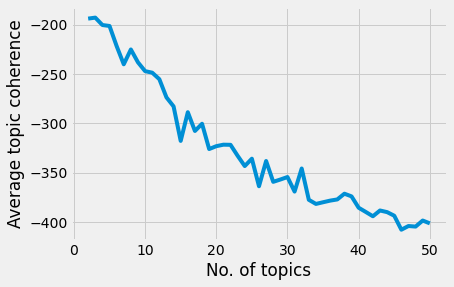

In [126]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_df_lda['n_topics'],measures_specific_df_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [127]:
measures_specific_df_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

avg_coherence  n_topics
1    -192.780806         3
0    -193.780499         2
2    -200.281433         4
3    -201.235622         5
4    -221.594747         6
6    -225.058841         8
7    -238.113241         9
5    -240.070983         7
8    -247.007112        10

In [67]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

measures_specific = []

for n_topics in range(2,51,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, 
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 5, 
                                    random_state = 42)
                
    lda.fit(tfidf)
    
    avg_coherence = get_average_topic_coherence(tfidf, lda.components_, 25)

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

In [128]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_tfidf_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

save_object(measures_specific_tfidf_lda, 'TM_project/measures_specific_tfidf_lda.pkl')

In [129]:
with open("TM_project/measures_specific_tfidf_lda.pkl", "rb") as fp:
    measures_specific_tfidf_lda = pickle.load(fp)

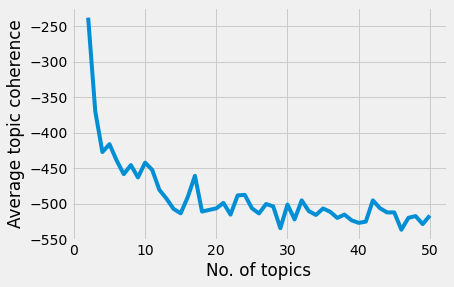

In [130]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_tfidf_lda['n_topics'],measures_specific_tfidf_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [131]:
measures_specific_tfidf_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

avg_coherence  n_topics
0    -237.808880         2
1    -370.189453         3
3    -416.302235         5
2    -427.433140         4
4    -439.275332         6
8    -442.340813        10
6    -445.821198         8
9    -452.604066        11
5    -458.611878         7

In [132]:
# here we consider the previously presented LatentDirichletAllocation() function, still with less parameters
lda = LatentDirichletAllocation(n_components = 10, 
                                learning_method = 'online', 
                                learning_offset = 80.0,
                                max_iter = 5, 
                                random_state = 42)
lda.fit(tfidf)

LatentDirichletAllocation(learning_method='online', learning_offset=80.0,
                          max_iter=5, random_state=42)

In [ ]:
for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['his', 'his mom', 'college', 'school', 'princess', 'asked why said', 'family', 'girls', 'mom', 'going']
Topic 1:  ['listen', 'anymore', 'hes', 'big', 'his', 'asking was', 'begging', 'wedding', 'special', 'celebratory dinner']
Topic 2:  ['adam', 'work', 'shouting', 'think its', 'this morning', 'dog', 'very much', 'drink', 'fair', 'would like']
Topic 3:  ['his', 'family', 'house', 'hold', 'started', 'like', 'get', 'husband', 'mom', 'friend']
Topic 4:  ['approached', 'full time', 'year old daughter', 'welcome', 'dead', 'couple days', 'cancelled', 'comment', 'bother', 'son his']
Topic 5:  ['his', 'husband', 'im', 'mom', 'sister', 'family', 'like', 'wife', 'get', 'parents']
Topic 6:  ['his', 'brother', 'blue', 'years', 'new', 'im', 'dead', 'job', 'husband', 'fund']
Topic 7:  ['im', 'sister', 'carrying', 'parents', 'went', 'ive', 'was serious', 'income', 'saturday', 'still']
Topic 8:  ['son', 'husband', 'tradition', 'family dinner', 'said was', 'dress', 'always', 'his', 'give', 'h

In [82]:
params = []
for alpha in [0.0001, 0.001, 0.01, 0.05, 0.1]:
    for beta in [0.0001, 0.001, 0.01, 0.05, 0.1]:
        for vectorizer_name in ['tf','tf-idf']:
            
            if(vectorizer_name == 'tf'):
                print(alpha, beta, 'tf')
                lda = LatentDirichletAllocation(n_components = 10, 
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online', 
                                                learning_offset = 50.0,
                                                max_iter = 5, 
                                                random_state = 42)
                lda.fit(tf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf', avg_coherence])
                    
            if(vectorizer_name == 'tf-idf'):
                print(alpha, beta, 'tf-idf')
                lda = LatentDirichletAllocation(n_components = 10, 
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online', 
                                                learning_offset = 50.0,
                                                max_iter = 5, 
                                                random_state = 42)
                lda.fit(tfidf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf-idf', avg_coherence])

0.0001 0.0001 tf
0.0001 0.0001 tf-idf
0.0001 0.001 tf
0.0001 0.001 tf-idf
0.0001 0.01 tf
0.0001 0.01 tf-idf
0.0001 0.05 tf
0.0001 0.05 tf-idf
0.0001 0.1 tf
0.0001 0.1 tf-idf
0.001 0.0001 tf
0.001 0.0001 tf-idf
0.001 0.001 tf
0.001 0.001 tf-idf
0.001 0.01 tf
0.001 0.01 tf-idf
0.001 0.05 tf
0.001 0.05 tf-idf
0.001 0.1 tf
0.001 0.1 tf-idf
0.01 0.0001 tf
0.01 0.0001 tf-idf
0.01 0.001 tf
0.01 0.001 tf-idf
0.01 0.01 tf
0.01 0.01 tf-idf
0.01 0.05 tf
0.01 0.05 tf-idf
0.01 0.1 tf
0.01 0.1 tf-idf
0.05 0.0001 tf
0.05 0.0001 tf-idf
0.05 0.001 tf
0.05 0.001 tf-idf
0.05 0.01 tf
0.05 0.01 tf-idf
0.05 0.05 tf
0.05 0.05 tf-idf
0.05 0.1 tf
0.05 0.1 tf-idf
0.1 0.0001 tf
0.1 0.0001 tf-idf
0.1 0.001 tf
0.1 0.001 tf-idf
0.1 0.01 tf
0.1 0.01 tf-idf
0.1 0.05 tf
0.1 0.05 tf-idf
0.1 0.1 tf
0.1 0.1 tf-idf


In [83]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
params_df = pd.DataFrame(params).rename(columns={
    0: 'alpha', 1: 'beta', 2: 'vectorizer', 3: 'avg_coherence'
})

save_object(params_df, 'TM_project/params_df.pkl')

In [133]:
with open("TM_project/params_df.pkl", "rb") as fp:
    params_df = pickle.load(fp)

In [134]:
params_df.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

alpha    beta vectorizer  avg_coherence
4   0.0001  0.0100         tf    -240.468495
14  0.0010  0.0100         tf    -240.489874
0   0.0001  0.0001         tf    -240.715091
2   0.0001  0.0010         tf    -240.715091
10  0.0010  0.0001         tf    -240.778999
12  0.0010  0.0010         tf    -240.778999
6   0.0001  0.0500         tf    -240.823886
16  0.0010  0.0500         tf    -240.887794
8   0.0001  0.1000         tf    -241.310168

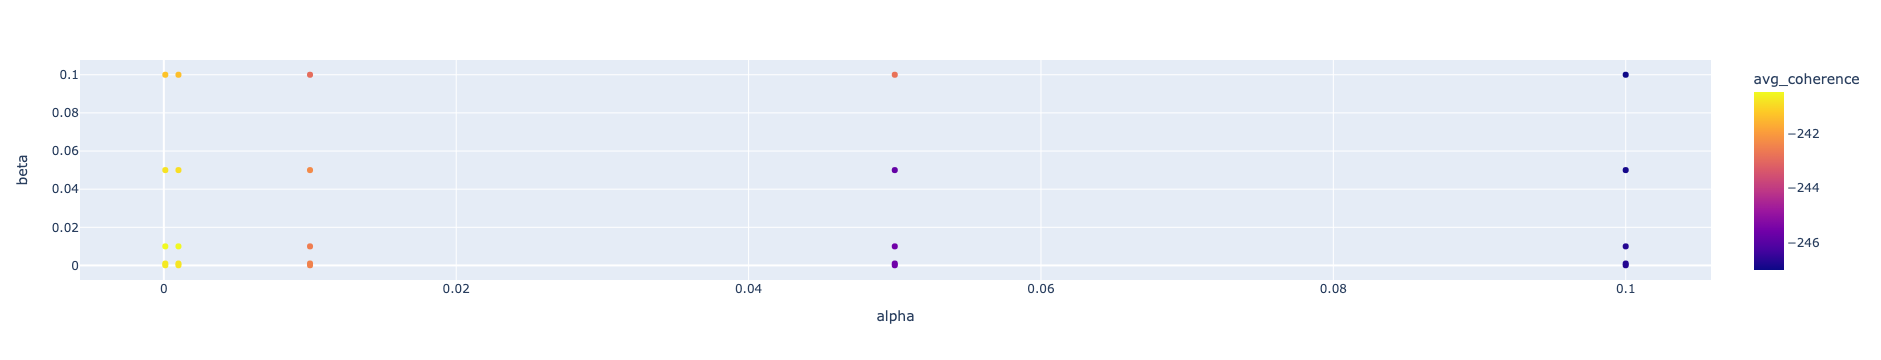

In [135]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

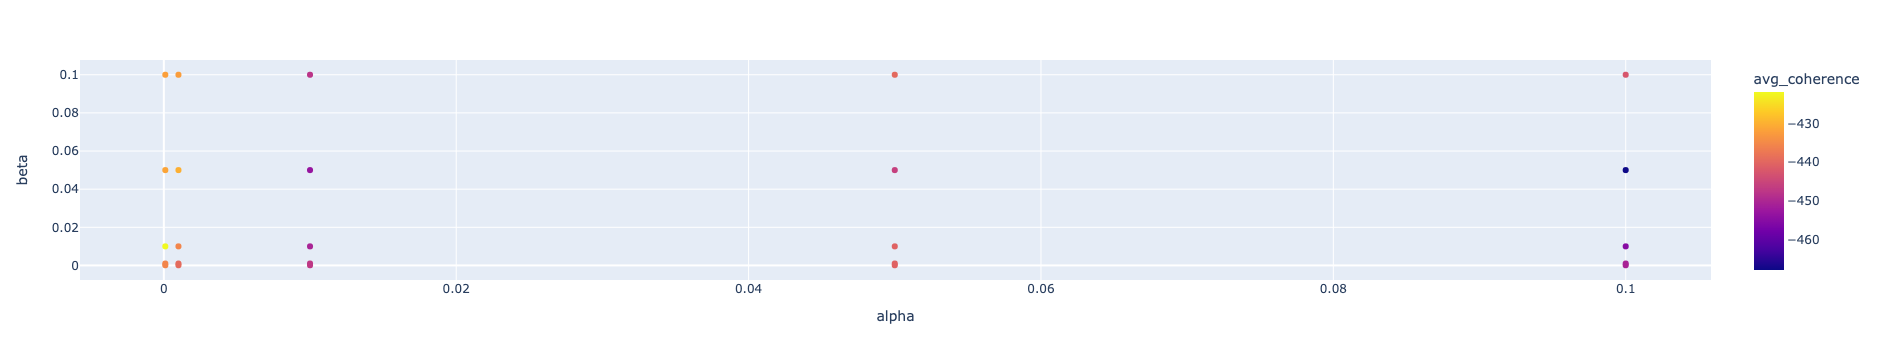

In [136]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf-idf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

In [144]:
lda = LatentDirichletAllocation(n_components = 10, # let us stay with 30, as that is what topic coherence initially recommended 
                                doc_topic_prior = 0.0001,
                                topic_word_prior = 0.0100,
                                learning_method = 'online', 
                                learning_offset = 10.0,
                                max_iter = 20, 
                                random_state = 42)
lda.fit(tf) # TF for now

topics_lists = []

for index, component in enumerate(lda.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    topics_lists.append(top_terms_list)
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['teacher', 'class', 'teaching', 'teach', 'bedroom', 'girls', 'email', 'asking', 'boundaries', 'five']
Topic 1:  ['gf', 'seat', 'uncomfortable', 'next', 'feel uncomfortable', 'nasty', 'plane', 'flight', 'empty', 'quietly']
Topic 2:  ['work', 'hr', 'coworkers', 'email', 'saying', 'meeting', 'like', 'sent', 'office', 'inappropriate']
Topic 3:  ['results', 'gifts', 'gift', 'relatives', 'appointment', 'first', 'familys', 'expecting', 'babys', 'well']
Topic 4:  ['mom', 'his', 'wedding', 'dress', 'im', 'us', 'his mom', 'made', 'one', 'get']
Topic 5:  ['his', 'im', 'like', 'family', 'would', 'get', 'time', 'has', 'its', 'one']
Topic 6:  ['dress', 'wedding', 'color', 'wearing', 'asked', 'white', 'wear', 'would', 'dress was', 'bride']
Topic 7:  ['im', 'flight', 'his friends', 'maybe', 'guy', 'tell', 'trying', 'plane', 'talk', 'sleep']
Topic 8:  ['his', 'husband', 'mom', 'im', 'home', 'went', 'like', 'his mom', 'dinner', 'get']
Topic 9:  ['his', 'cake', 'husband', 'its', 'im', 'daughte

In [139]:
import os
import openai
from IPython.display import Image
from IPython import display
from base64 import b64decode

In [140]:
openai.api_key = ""

In [175]:
images = []

for i in range(len(topics_lists)):
    
    try:
        topic_prompt = " ".join(topics_lists[i])

        response = openai.Image.create(
            prompt=topic_prompt,
            n=1,
            size="512x512",
            response_format="b64_json"
        )

        images.append((i,response['data'][0]['b64_json']))

        print(i)
    except:
        images.append((i, np.nan))
        print(i)
        print("too NSFW for OpenAI")

0
too NSFW for OpenAI
1
2
3
4
5
6
7
8
9


In [176]:
image_df = pd.DataFrame(images, columns =['topic', 'image'])
image_df["words"] = topics_lists

image_df.head()

topic                                              image  \
0      0                                                NaN   
1      1  iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...   
2      2  iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...   
3      3  iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...   
4      4  iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...   

                                               words  
0  [teacher, class, teaching, teach, bedroom, gir...  
1  [gf, seat, uncomfortable, next, feel uncomfort...  
2  [work, hr, coworkers, email, saying, meeting, ...  
3  [results, gifts, gift, relatives, appointment,...  
4  [mom, his, wedding, dress, im, us, his mom, ma...

In [177]:
len(image_df)

10

Image for topic  0  with words:
['teacher', 'class', 'teaching', 'teach', 'bedroom', 'girls', 'email', 'asking', 'boundaries', 'five']
Too NSFW for OpenAI
Image for topic  1  with words:
['gf', 'seat', 'uncomfortable', 'next', 'feel uncomfortable', 'nasty', 'plane', 'flight', 'empty', 'quietly']


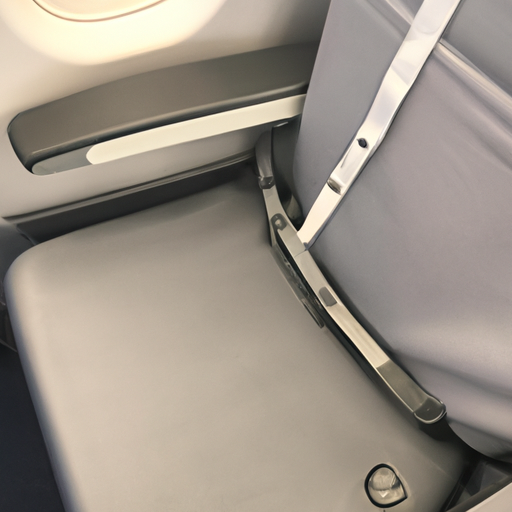

Image for topic  2  with words:
['work', 'hr', 'coworkers', 'email', 'saying', 'meeting', 'like', 'sent', 'office', 'inappropriate']


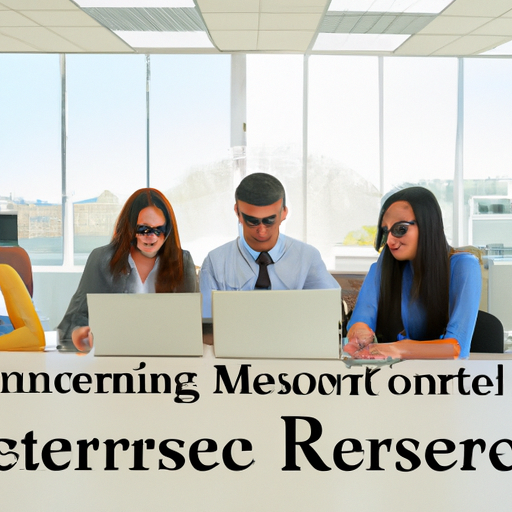

Image for topic  3  with words:
['results', 'gifts', 'gift', 'relatives', 'appointment', 'first', 'familys', 'expecting', 'babys', 'well']


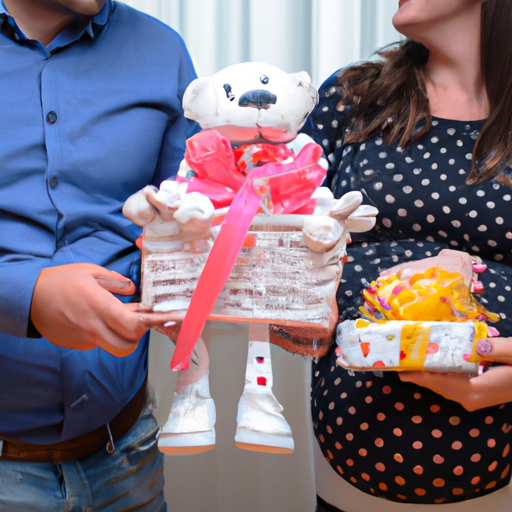

Image for topic  4  with words:
['mom', 'his', 'wedding', 'dress', 'im', 'us', 'his mom', 'made', 'one', 'get']


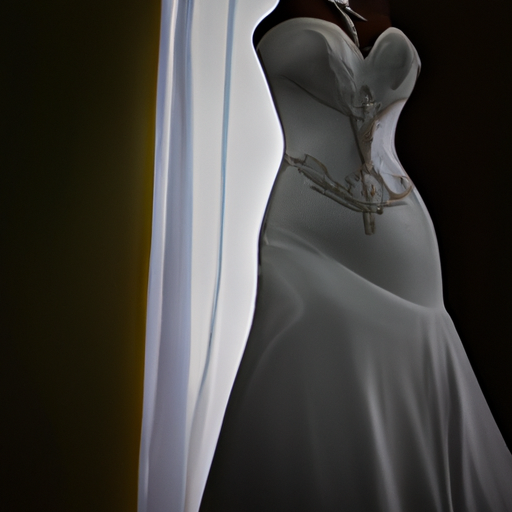

Image for topic  5  with words:
['his', 'im', 'like', 'family', 'would', 'get', 'time', 'has', 'its', 'one']


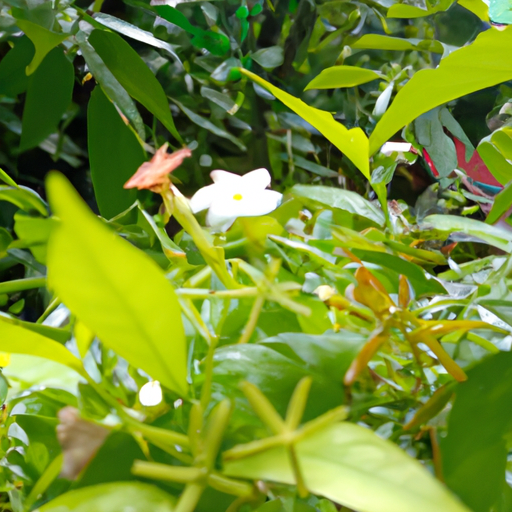

Image for topic  6  with words:
['dress', 'wedding', 'color', 'wearing', 'asked', 'white', 'wear', 'would', 'dress was', 'bride']


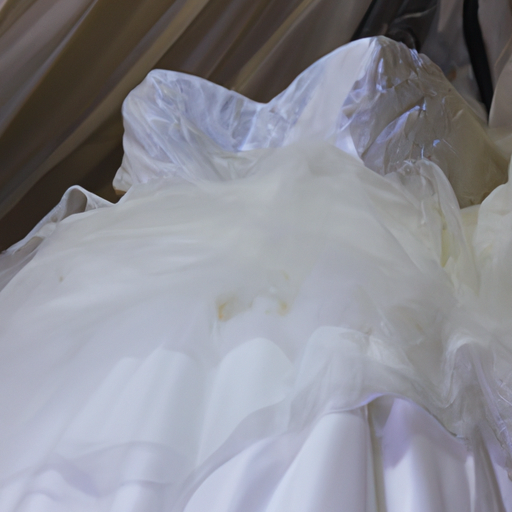

Image for topic  7  with words:
['im', 'flight', 'his friends', 'maybe', 'guy', 'tell', 'trying', 'plane', 'talk', 'sleep']


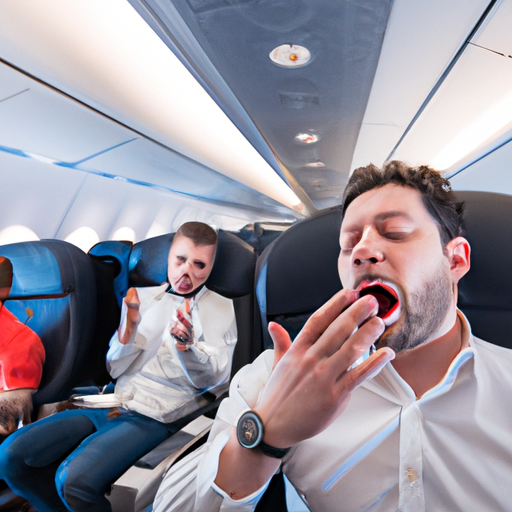

Image for topic  8  with words:
['his', 'husband', 'mom', 'im', 'home', 'went', 'like', 'his mom', 'dinner', 'get']


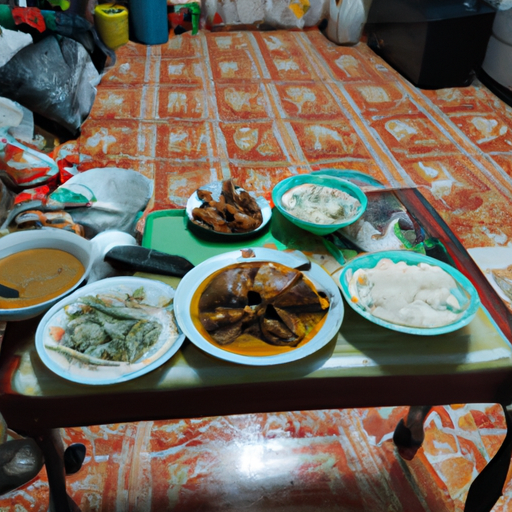

Image for topic  9  with words:
['his', 'cake', 'husband', 'its', 'im', 'daughter', 'like', 'go', 'being', 'kids']


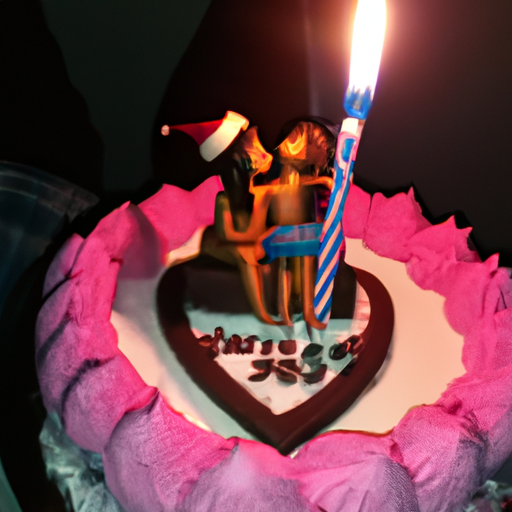

In [178]:
for i in range(len(image_df)):
    print("Image for topic ", i, " with words:")
    print(image_df.loc[i,"words"])
    try:
        display.display(display.Image(b64decode(image_df.loc[i,"image"])))
    except:
        print("Too NSFW for OpenAI")

In [199]:
df_topics_for_posts = pd.DataFrame(lda.transform(tf).tolist())

df_topics_for_posts.head()

0             1             2             3             4  \
0  6.849268e-07  6.849268e-07  6.849268e-07  6.849268e-07  6.849268e-07   
1  4.347807e-07  4.347807e-07  4.347807e-07  4.347807e-07  4.347807e-07   
2  4.629608e-07  4.629608e-07  4.629608e-07  4.629608e-07  4.629608e-07   
3  3.787864e-07  8.905409e-03  3.787864e-07  3.787864e-07  3.787864e-07   
4  3.831403e-07  3.831403e-07  3.831403e-07  3.831403e-07  3.831403e-07   

              5             6             7             8             9  
0  7.937264e-01  6.849268e-07  6.849268e-07  2.062681e-01  6.849268e-07  
1  9.999961e-01  4.347807e-07  4.347807e-07  4.347807e-07  4.347807e-07  
2  8.314305e-01  3.879889e-02  4.629608e-07  1.297673e-01  4.629608e-07  
3  7.637727e-01  3.787864e-07  3.787864e-07  2.273193e-01  3.787864e-07  
4  3.831403e-07  3.831403e-07  3.831403e-07  9.999966e-01  3.831403e-07

In [208]:
top_posts_final = pd.merge(top_posts, round(df_topics_for_posts*100, 3), left_index=True, right_index=True)

top_posts_final.head()

title  \
0  AITA for bringing my SIL’s wallet to the resta...   
1  AITA for bringing up my brother's "premature" ...   
2  AITA for not taking down my video that was a g...   
3  UPDATE AITA for walking out of the Airport whe...   
4  AITA for walking out of the Airport when I saw...   

                                                body  score      id  \
0  Edit: update on profile\n\nMy (f28) SIL “Amy” ...  68476  x2k5kv   
1  I am a nurse practitioner and I am the primary...  56113  zvmflw   
2  I have a sister that’s 6 years older than me. ...  54700  wyjbjs   
3  Hello!.\n\n\nI don't know where to begin...it'...  51466  ur2l3s   
4  \n\nI F30 don't have the best relationship wit...  50032  unhse2   

                                    top_comment_body  top_comment_score  \
0  NTA. Stone cold busted. Next time she books an...               1443   
1  You can tell the family about the time you wer...                673   
2  NTA\n\nMy parents missed my wedding too all be...               1563   
3  I'm sorry you are going through this, but I'm ...              18673   
4  Definitely NTA. You know that if you had sucke...               9414   

                                                 url  \
0  https://www.reddit.com/r/AmItheAsshole/comment...   
1  https://www.reddit.com/r/AmItheAsshole/comment...   
2  https://www.reddit.com/r/AmItheAsshole/comment...   
3  https://www.reddit.com/r/AmItheAsshole/comment...   
4  https://www.reddit.com/r/AmItheAsshole/comment...   

                                          body_clean  \
0  [edit, update, profile, sil, amy, always, come...   
1  [nurse, practitioner, primary, care, provider,...   
2  [sister, thats, years, older, parents, years, ...   
3  [hello, know, beginits, absolute, nightmare, r...   
4  [best, relationship, husbands, mom, since, day...   

                                      body_clean_str    0      1    2    3  \
0  edit update profile sil amy always comes visit...  0.0  0.000  0.0  0.0   
1  nurse practitioner primary care provider lot l...  0.0  0.000  0.0  0.0   
2  sister thats years older parents years cancel ...  0.0  0.000  0.0  0.0   
3  hello know beginits absolute nightmare recentl...  0.0  0.891  0.0  0.0   
4  best relationship husbands mom since day one t...  0.0  0.000  0.0  0.0   

     4        5     6    7        8    9  
0  0.0   79.373  0.00  0.0   20.627  0.0  
1  0.0  100.000  0.00  0.0    0.000  0.0  
2  0.0   83.143  3.88  0.0   12.977  0.0  
3  0.0   76.377  0.00  0.0   22.732  0.0  
4  0.0    0.000  0.00  0.0  100.000  0.0

In [ ]:
save_object(top_posts_final, 'TM_project/final_df.pkl')